In [1]:
import os
from dotenv import load_dotenv
from openai import OpenAI
import google.generativeai as genai
import anthropic
import gradio as gr

In [2]:
# Load environment variables in a file called .env

load_dotenv()
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY", "your-key-if-not-using-env")
os.environ["ANTHROPIC_API_KEY"] = os.getenv(
    "ANTHROPIC_API_KEY", "your-key-if-not-using-env"
)
os.environ["GOOGLE_API_KEY"] = os.getenv("GOOGLE_API_KEY", "your-key-if-not-using-env")

In [3]:
system_message = "You are a helpful assistant that analyzes the content of an article and provides a summary in markdown."
prompt = "Please provide a short summary of the article in markdown format."

In [4]:
# Connect to OpenAI, Anthropic and Google

openai = OpenAI()

claude = anthropic.Anthropic()

genai.configure()

In [5]:
# Let's wrap a call to GPT-4o-mini in a simple function

def summarize_gpt(prompt=prompt):
    messages = [
        {"role": "system", "content": system_message},
        {"role": "user", "content": prompt},
    ]
    response = openai.chat.completions.create(
        model="gpt-4o-mini", messages=messages, stream=False
    )
    return response.choices[0].message.content

In [6]:
def summarize_claude(article_text):
    """
    Sends an article to the Anthropic API to generate a summary.
    
    Parameters:
    article_text (str): The full text of the article to be summarized.
    
    Returns:
    str: The summary of the article generated by the Anthropic API.
    """
    
    system_message = """
    You are an AI assistant tasked with summarizing articles. Your goal is to provide a concise, accurate, and informative summary of the key points in the given article text. Focus on capturing the main ideas, key findings, and important conclusions. Avoid including unnecessary details or tangents. The summary should be approximately 1-2 paragraphs in length.
    """
    
    try:
        response = claude.messages.create(
            model="claude-3-haiku-20240307",
            max_tokens=1000,
            system = system_message,
            messages = [
                {"role": "user", "content": article_text}
            ]
        )
        return response.content[0].text
    except Exception as e:
        raise Exception(f"Error summarizing article: {e}")

In [7]:
def gemini(prompt=prompt):
    gemini = genai.GenerativeModel(
    model_name='gemini-1.5-flash',
    system_instruction=system_message
    )
    response = gemini.generate_content(prompt)
    return response.candidates[0].content.parts[0].text

In [8]:
import pandas as pd

# Read a sample article from a CSV file
df = pd.read_csv("articles.csv")
df.head()

,article_id,full_text,ABSTRACT
0,PMC11315657,Exploring the association between melatonin an...,Due to the addictive qualities of tobacco prod...
1,PMC11204383,Antibodies Against ZSCAN1 in Pediatric and Adu...,"Objectives, To report the association of zinc ..."
2,PMC11301388,Gingival mesenchymal stem cells: Biological pr...,Our understanding of mesenchymal stem cells (M...
3,PMC11240861,Research progress of DNA methylation in colore...,DNA methylation is one of the earliest and mos...
4,PMC11289611,"Investigating the Relationship of Serum CD163,...","Objective, This study aimed to compare serum l..."


In [9]:
# Select the first article
article = df["full_text"][0]
abstract = df["ABSTRACT"][0]

In [10]:
openai_response = summarize_gpt(article)
print(openai_response)

# Summary: Exploring the Association Between Melatonin and Nicotine Dependence

## Introduction
Nicotine dependence is a significant public health concern characterized by addictive behavior and various health issues. Despite extensive research, effective strategies for preventing and treating nicotine dependence remain challenging. An emerging area of interest is the interplay between nicotine dependence and the neuroendocrine hormone melatonin.

## Nicotine Dependence
Nicotine addiction activates the brain's reward pathways, particularly the mesolimbic dopaminergic system, leading to compulsive cravings. The condition poses risks for numerous health issues, including cardiovascular disease, respiratory disorders, and cancer.

## Melatonin
Melatonin, produced by the pineal gland, regulates circadian rhythms and has various physiological roles including:
- **Antioxidant Properties:** Protects cells from oxidative stress.
- **Immunomodulatory Effects:** Regulates immune responses and pr

In [11]:
# Use the Anthropic API to summarize the article
anthropic_response = summarize_claude(article)
print(anthropic_response)

Here is a concise summary of the key points from the article:

The article explores the potential association between melatonin, the "hormone of darkness," and nicotine dependence. Nicotine addiction is a major public health challenge, contributing to numerous health issues including cardiovascular disease, respiratory disorders, and cancer. 

Melatonin receptors are widely distributed in the brain, including regions involved in the reward pathway and addiction-related behaviors. Preclinical studies suggest melatonin may modulate the reinforcing effects of nicotine by influencing neurotransmitter systems like dopamine, glutamate, GABA, and serotonin. This indicates melatonin could play a role in regulating nicotine cravings and withdrawal symptoms.

The article also discusses the potential therapeutic applications of targeting melatonin for nicotine dependence. Melatonin supplementation may help alleviate nicotine withdrawal symptoms, and combining melatonin-based interventions with ex

In [12]:
# Use the Google Generative AI API to summarize the article
gemini_response = gemini(article)
print(gemini_response)

## Melatonin and Nicotine Dependence: A Comprehensive Review

This article comprehensively reviews the current understanding of the association between melatonin, the "hormone of darkness," and nicotine dependence. The review examines the diverse physiological roles of melatonin, the mechanisms underlying nicotine addiction, and the potential interplay between these two factors.

### Melatonin's Diverse Roles

* **Circadian Rhythms:** Melatonin plays a crucial role in regulating circadian rhythms, promoting sleep onset and regulating the sleep-wake cycle.
* **Antioxidant Properties:** Melatonin scavenges free radicals and protects cells from oxidative stress.
* **Immunomodulatory Effects:** Melatonin regulates immune responses by enhancing the production of immune cells and exhibiting anti-inflammatory properties.
* **Neuroprotective Effects:** Melatonin safeguards the brain by regulating neurotransmitter release, modulating neuronal excitability and promoting neuronal survival.
* **Re

In [13]:
import evaluate

In [14]:
rouge = evaluate.load("rouge")

# Evaluate the summaries generated by the different models
openai_scores = rouge.compute(predictions=[openai_response], references=[abstract])
print("OpenAI gemini-1.5-flash Scores:")
print(openai_scores)

OpenAI gemini-1.5-flash Scores:
{'rouge1': 0.48721804511278194, 'rouge2': 0.15987933634992457, 'rougeL': 0.23759398496240602, 'rougeLsum': 0.3097744360902256}


In [15]:
anthropic_scores = rouge.compute(predictions=[anthropic_response], references=[abstract])
print("Anthropic Scores:")
print(anthropic_scores)

Anthropic Scores:
{'rouge1': 0.5070993914807301, 'rouge2': 0.17515274949083504, 'rougeL': 0.24340770791075053, 'rougeLsum': 0.2799188640973631}


In [16]:
genai_scores = rouge.compute(predictions=[gemini_response], references=[abstract])
print("Google Generative AI Scores:")
print(genai_scores)

Google Generative AI Scores:
{'rouge1': 0.42524271844660194, 'rouge2': 0.14396887159533073, 'rougeL': 0.2, 'rougeLsum': 0.30873786407766984}


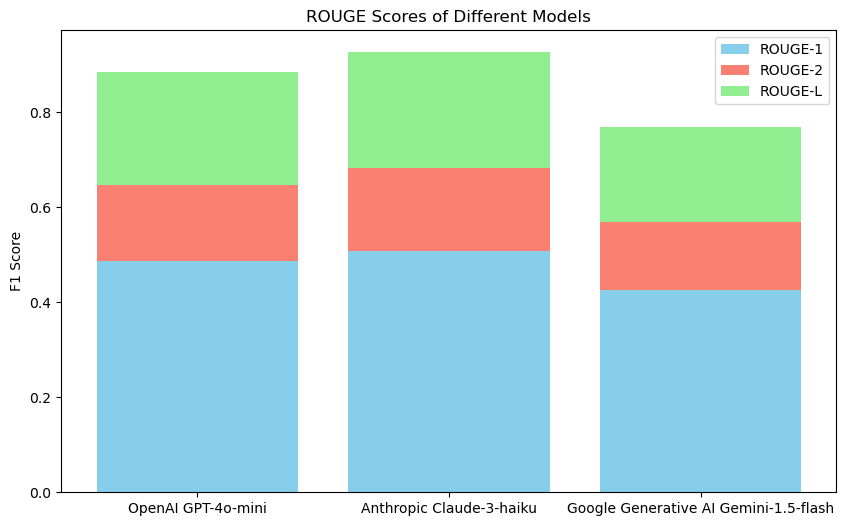

In [18]:
# Create a chart to compare the ROUGE scores of the different models

import matplotlib.pyplot as plt

models = ["OpenAI GPT-4o-mini", "Anthropic Claude-3-haiku", "Google Generative AI Gemini-1.5-flash"]

rouge_1_scores = [openai_scores["rouge1"], anthropic_scores["rouge1"], genai_scores["rouge1"]]
rouge_2_scores = [openai_scores["rouge2"], anthropic_scores["rouge2"], genai_scores["rouge2"]]
rouge_l_scores = [openai_scores["rougeL"], anthropic_scores["rougeL"], genai_scores["rougeL"]]

plt.figure(figsize=(10, 6))

# Stack the bars using variable names for scores
plt.bar(models, rouge_1_scores, color="skyblue", label="ROUGE-1")
plt.bar(models, rouge_2_scores, bottom=rouge_1_scores, color="salmon", label="ROUGE-2")
plt.bar(models, rouge_l_scores, bottom=[i+j for i,j in zip(rouge_1_scores, rouge_2_scores)], color="lightgreen", label="ROUGE-L")

plt.ylabel("F1 Score")
plt.title("ROUGE Scores of Different Models")
plt.legend()
plt.show()

In [25]:
# Create a Gradio interface to summarize articles using the different models

def summarize_article(prompt, model):
    if model == "GPT":
        return summarize_gpt(prompt)
    elif model == "Claude":
        return summarize_claude(prompt)
    elif model == "Gemini":
        return gemini(prompt)

In [31]:
view = gr.Interface(
    fn=summarize_article,
    inputs=[
        gr.Textbox(label="Your article:"),
        gr.Dropdown(["GPT", "Claude", "Gemini"], label="Select model", value="GPT"),
    ],
    outputs=[gr.Markdown(label="Summary")],
    flagging_mode="never",
    description="Summarize an article using different models.",
)

view.launch(share=True)

* Running on local URL:  http://127.0.0.1:7869

Could not create share link. Please check your internet connection or our status page: https://status.gradio.app.


2024/11/11 13:36:07 [W] [service.go:132] login to server failed: session shutdown


## To do: Fine-tuning LLM for our use case